In [1]:
import os
import sys
import random
from glob import glob
from copy import deepcopy
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from mejiro.utils import util
from mejiro.instruments.hwo import HWO

# set matplotlib style
# plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

# set HWO directory
hwo_dir = '/grad/bwedig/mejiro/projects/hwo'

Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.


/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/pysynphot/units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.


In [2]:
hwo_eac1 = HWO(eac='EAC1')
print(f'EAC1: {hwo_eac1.aperture}, J-band PSF FWHM: {hwo_eac1.get_psf_fwhm(band="J"):.3f}, J-band zeropoint: {hwo_eac1.get_zeropoint_magnitude(band="J"):.3f}')

hwo_eac2 = HWO(eac='EAC2')  
print(f'EAC2: {hwo_eac2.aperture}, J-band PSF FWHM: {hwo_eac2.get_psf_fwhm(band="J"):.3f}, J-band zeropoint: {hwo_eac2.get_zeropoint_magnitude(band="J"):.3f}')

hwo_eac3 = HWO(eac='EAC3')
print(f'EAC3: {hwo_eac3.aperture}, J-band PSF FWHM: {hwo_eac3.get_psf_fwhm(band="J"):.3f}, J-band zeropoint: {hwo_eac3.get_zeropoint_magnitude(band="J"):.3f}')

EAC1: 7.2 m, J-band PSF FWHM: 0.037 arcsec2, J-band zeropoint: 29.130
EAC2: 6.0 m, J-band PSF FWHM: 0.045 arcsec2, J-band zeropoint: 28.734
EAC3: 8.0 m, J-band PSF FWHM: 0.033 arcsec2, J-band zeropoint: 29.359


In [3]:
logm_low = 4
logm_high = 10
num_bins = 1000

In [4]:
def get_subhalo_params(detectable_subhalos):
    """
    Returns the redshift, mass, and concentration of detectable subhalos
    """    
    z_list, m_list, c_list = [], [], []
    for halo_list in detectable_subhalos:
        for z, m, c in halo_list:
            z_list.append(z)
            m_list.append(m)
            c_list.append(c)
    return z_list, m_list, c_list

In [5]:
def get_scatter_kwargs(data_dir, eac, band, prefix):
    subhalos = util.unpickle_all(os.path.join(data_dir, f'eac{eac}_{band}'), prefix, '.pkl')
    z_list, m_list, c_list = get_subhalo_params(subhalos)
    return {
        'x': np.log10(m_list),
        'y': c_list,
        # 'label': f'EAC{eac} {band}',
    }

/tmp/ipykernel_1665636/1349515555.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


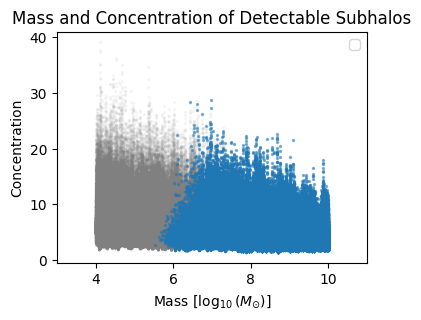

In [6]:
data_dir = '/data/bwedig/mejiro/hwo_subhalo_detection_compare'

f, ax = plt.subplots(figsize=(4, 3))

ax.scatter(**get_scatter_kwargs(data_dir, 1, 'J', 'undetectable_halos_'), s=2, alpha=0.05, color='grey')
ax.scatter(**get_scatter_kwargs(data_dir, 1, 'J', 'detectable_halos_'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 2, 'J'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 3, 'J'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 1, 'I'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 2, 'I'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 3, 'I'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 1, 'H'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 2, 'H'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 3, 'H'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 1, 'K'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 2, 'K'), s=2, alpha=0.5)
# ax.scatter(**get_scatter_kwargs(data_dir, 3, 'K'), s=2, alpha=0.5)

plt.xlabel(r'Mass [$\log_{10}(M_{\odot})$]')
plt.ylabel('Concentration')
plt.xlim(logm_low - 1, logm_high + 1)
plt.legend()
plt.title('Mass and Concentration of Detectable Subhalos')
plt.savefig(os.path.join(hwo_dir, 'figures', 'detectable_subhalos.png'))
plt.show()

In [7]:
def get_percent_detectable(m_list, detectable_halos):
    percent_det = []
    mlog10_list = [np.log10(m) for m in np.logspace(logm_low, logm_high, num_bins)]
    m_list = [np.log10(m) for m in m_list]

    for m in mlog10_list:
        count = np.sum(np.array(m_list) == m)
        percent_det.append(count / len(detectable_halos))

    return percent_det

In [8]:
def get_plot_kwargs(data_dir, eac, band):
    mlog10_list = [np.log10(m) for m in np.logspace(logm_low, logm_high, num_bins)]  # 
    detectable_subhalos = util.unpickle_all(os.path.join(data_dir, f'eac{eac}_{band}'), 'detectable_halos_', '.pkl')
    z_list, m_list, c_list = get_subhalo_params(detectable_subhalos)
    return mlog10_list, get_percent_detectable(m_list, detectable_subhalos)

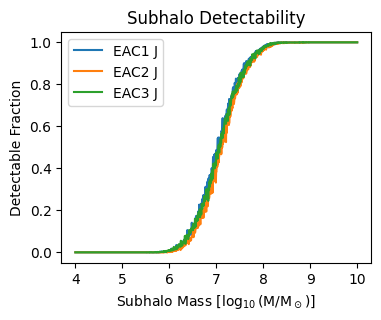

In [9]:
f, ax = plt.subplots(figsize=(4, 3))  # 
ax.plot(*get_plot_kwargs(data_dir, 1, 'J'), label='EAC1 J')
ax.plot(*get_plot_kwargs(data_dir, 2, 'J'), label='EAC2 J')
ax.plot(*get_plot_kwargs(data_dir, 3, 'J'), label='EAC3 J')
# ax.plot(*get_plot_kwargs(data_dir, 1, 'I'), label='EAC1 I')
# ax.plot(*get_plot_kwargs(data_dir, 2, 'I'), label='EAC2 I')
# ax.plot(*get_plot_kwargs(data_dir, 3, 'I'), label='EAC3 I')
# ax.plot(*get_plot_kwargs(data_dir, 1, 'H'), label='EAC1 H')
# ax.plot(*get_plot_kwargs(data_dir, 2, 'H'), label='EAC2 H')
# ax.plot(*get_plot_kwargs(data_dir, 3, 'H'), label='EAC3 H')
# ax.plot(*get_plot_kwargs(data_dir, 1, 'K'), label='EAC1 K')
# ax.plot(*get_plot_kwargs(data_dir, 2, 'K'), label='EAC2 K')
# ax.plot(*get_plot_kwargs(data_dir, 3, 'K'), label='EAC3 K')
ax.legend()
ax.set_ylabel('Detectable Fraction')
ax.set_xlabel(r'Subhalo Mass [$\log_{10}($M/M$_\odot)$]')
plt.title('Subhalo Detectability')
plt.savefig(os.path.join(hwo_dir, 'figures', 'subhalo_detection_compare.png'))
plt.show()

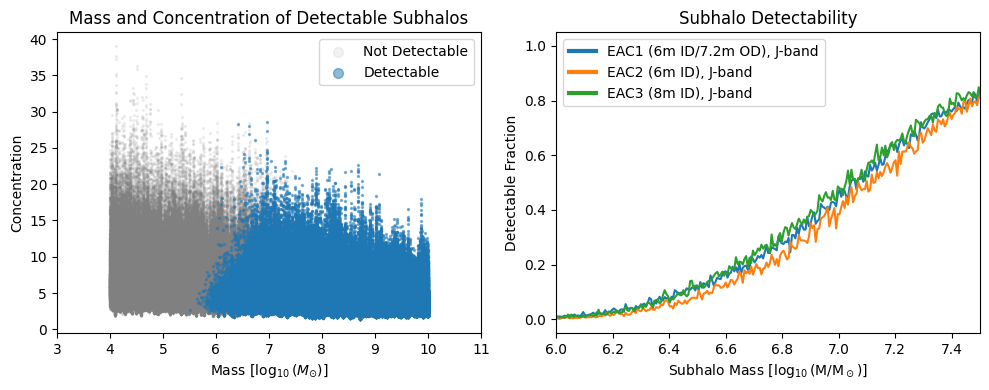

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Scatter plot: Mass vs Concentration of Detectable Subhalos
ax1.scatter(**get_scatter_kwargs(data_dir, 1, 'J', 'undetectable_halos_'), s=2, alpha=0.1, color='grey', label='Not Detectable')
ax1.scatter(**get_scatter_kwargs(data_dir, 1, 'J', 'detectable_halos_'), s=2, alpha=0.5, label='Detectable')
ax1.set_xlabel(r'Mass [$\log_{10}(M_{\odot})$]')
ax1.set_ylabel('Concentration')
ax1.set_xlim(logm_low - 1, logm_high + 1)
ax1.legend(markerscale=5)
ax1.set_title('Mass and Concentration of Detectable Subhalos')

# Line plot: Subhalo Detectability
ax2.plot(*get_plot_kwargs(data_dir, 3, 'J'), label='EAC1 (6m ID/7.2m OD), J-band')
ax2.plot(*get_plot_kwargs(data_dir, 2, 'J'), label='EAC2 (6m ID), J-band')
ax2.plot(*get_plot_kwargs(data_dir, 1, 'J'), label='EAC3 (8m ID), J-band')
legend = ax2.legend()
for line in legend.get_lines():
    line.set_linewidth(3)
ax2.set_ylabel('Detectable Fraction')
ax2.set_xlabel(r'Subhalo Mass [$\log_{10}($M/M$_\odot)$]')
ax2.set_title('Subhalo Detectability')
ax2.set_xlim(6, 7.5)  # Adjusted x-axis limits for better visibility

plt.tight_layout()
plt.savefig(os.path.join(hwo_dir, 'figures', 'combined_subhalo_plots.png'), dpi=600)
plt.show()